<a href="https://colab.research.google.com/github/hasibzunair/learn-pytorch/blob/master/notebooks/examples/mnist_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train CNN on MNIST dataset

Modified from [https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-lenet5-mnist.ipynb](https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-lenet5-mnist.ipynb)

## Imports

In [1]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

# Check GPU stuffs
# print(torch.cuda.device_count())
# print(torch.cuda.get_device_name(0))
# print(torch.cuda.is_available())

## Model Settings

In [2]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 32*32
NUM_CLASSES = 10

# Other
DEVICE = "cpu" # can be cuda:1,2 depending on machine configuration
GRAYSCALE = True

### MNIST Dataset

In [3]:
##########################
### MNIST DATASET
##########################

resize_transform = transforms.Compose([transforms.Resize((32, 32)),
                                       transforms.ToTensor()])
# transforms.ToTensor() scales input images
# to 0-1 range


train_dataset = datasets.MNIST(root='../../datasets', 
                               train=True, 
                               transform=resize_transform,
                               download=True)

test_dataset = datasets.MNIST(root='../../datasets', 
                              train=False, 
                              transform=resize_transform)


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

0.2%

36.4%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

78.0%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100.0%


Extracting ../../datasets/MNIST/raw/train-images-idx3-ubyte.gz to ../../datasets/MNIST/raw


102.8%


Extracting ../../datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ../../datasets/MNIST/raw




100.0%


Extracting ../../datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../datasets/MNIST/raw



112.7%

Extracting ../../datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../datasets/MNIST/raw

Image batch dimensions: torch.Size([128, 1, 32, 32])
Image label dimensions: torch.Size([128])



/Users/hasibzunair/anaconda3/envs/comp6321/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459044803/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Show image and label

In [4]:
def imshow(img, label):
  # Convert to numpy
  img = img.numpy()
  # Make to w,h from w,h,1
  img = img.squeeze()
  # Plot
  plt.imshow(img)
  plt.title("This is a {}".format(label))

In [5]:
# get some random training images
x, y = next(iter(train_loader)) # channels first!
x.shape, y.shape

(torch.Size([128, 1, 32, 32]), torch.Size([128]))

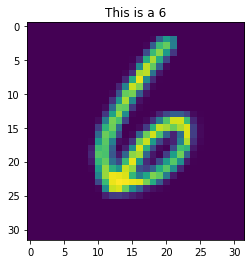

In [6]:
idx = 22
imshow(x[idx], y[idx])

### Training loop

In [7]:
# init device and seed
device = torch.device(DEVICE)
torch.manual_seed(0)

# iterate over epochs
for epoch in range(5):

    # iterate over each batch of the dataset
    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        # Send data to GPU
        x = x.to(device)
        y = y.to(device)

        # Do stuffs here
        break

Epoch: 1 | Batch index: 0 | Batch size: 128
Epoch: 2 | Batch index: 0 | Batch size: 128
Epoch: 3 | Batch index: 0 | Batch size: 128
Epoch: 4 | Batch index: 0 | Batch size: 128
Epoch: 5 | Batch index: 0 | Batch size: 128


### Model

In [8]:
##########################
### MODEL
##########################


class LeNet5(nn.Module):

    def __init__(self, num_classes, grayscale=False):
        super(LeNet5, self).__init__()
        
        self.grayscale = grayscale # True
        self.num_classes = num_classes # 10

        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3

        # define feature extractor
        self.features = nn.Sequential(
            # seriues of conv, activation, maxpool layers
            nn.Conv2d(in_channels, 6, kernel_size=5), # 6 is number of kernels 
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        # input features to the linear layer is defined by the dimensions 
        # of the activation coming from the previous layer 
        flattened = 16*5*5 # channels * height * width

        # define classifier head
        self.classifier = nn.Sequential(
            nn.Linear(flattened, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1) # x becomes shape (batch size, 16*5*5)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [9]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(NUM_CLASSES, GRAYSCALE)
model.to(DEVICE)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

LeNet5(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


### How many params to train?


In [10]:
# All parameters
all_params = sum(p.numel() for p in model.parameters())
print("All parameters ", all_params)

# Trainable parameters
all_train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable parameters ", all_train_params)

All parameters  61706
Trainable parameters  61706


## Training

In [11]:
def compute_accuracy(model, data_loader, device):
  """Compute acc on the val/test data"""
  correct_pred, num_examples = 0, 0
  for i, (features, targets) in enumerate(data_loader):
          
      features = features.to(device)
      targets = targets.to(device)
      # inference
      logits, probas = model(features)
      # argmax raw preds
      _, predicted_labels = torch.max(probas, 1)
      num_examples += targets.size(0)
      correct_pred += (predicted_labels == targets).sum()
  return correct_pred.float()/num_examples * 100
    

# Training looooop
start_time = time.time()
for epoch in range(NUM_EPOCHS):
    # Always set to train
    model.train()
    # Iterate over dataset
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        # Pass data to GPU
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP

        # Forward pass
        logits, probas = model(features)
        # Compute loss
        cost = F.cross_entropy(logits, targets)
        # Stop grads from piling up
        # Accumulates gradients by default which
        # is useful for training RNNs, not so 
        # much for classifiers, so clear cache of gradients! 
        optimizer.zero_grad()
        # Compute gradients
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))

    # Validation
    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Validation: %.3f%%' % (
              epoch+1, NUM_EPOCHS, 
              compute_accuracy(model, train_loader, device=DEVICE)))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

/Users/hasibzunair/anaconda3/envs/comp6321/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459044803/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 001/010 | Batch 0000/0469 | Cost: 2.3056
Epoch: 001/010 | Batch 0050/0469 | Cost: 0.5722
Epoch: 001/010 | Batch 0100/0469 | Cost: 0.2986
Epoch: 001/010 | Batch 0150/0469 | Cost: 0.2654
Epoch: 001/010 | Batch 0200/0469 | Cost: 0.2660
Epoch: 001/010 | Batch 0250/0469 | Cost: 0.1107
Epoch: 001/010 | Batch 0300/0469 | Cost: 0.2027
Epoch: 001/010 | Batch 0350/0469 | Cost: 0.1334
Epoch: 001/010 | Batch 0400/0469 | Cost: 0.1609
Epoch: 001/010 | Batch 0450/0469 | Cost: 0.0795
Epoch: 001/010 | Validation: 97.043%
Time elapsed: 0.42 min
Epoch: 002/010 | Batch 0000/0469 | Cost: 0.1570
Epoch: 002/010 | Batch 0050/0469 | Cost: 0.0803
Epoch: 002/010 | Batch 0100/0469 | Cost: 0.0452
Epoch: 002/010 | Batch 0150/0469 | Cost: 0.0685
Epoch: 002/010 | Batch 0200/0469 | Cost: 0.1666
Epoch: 002/010 | Batch 0250/0469 | Cost: 0.1194
Epoch: 002/010 | Batch 0300/0469 | Cost: 0.1153
Epoch: 002/010 | Batch 0350/0469 | Cost: 0.0416
Epoch: 002/010 | Batch 0400/0469 | Cost: 0.1264
Epoch: 002/010 | Batch 0450/

## Evaluation

In [12]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

Test accuracy: 98.80%


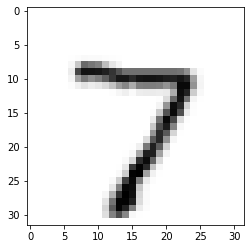

In [13]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break

    
nhwc_img = np.transpose(features[0], axes=(1, 2, 0))
nhw_img = np.squeeze(nhwc_img.numpy(), axis=2)
plt.imshow(nhw_img, cmap='Greys');

In [14]:
features.shape, targets.shape

(torch.Size([128, 1, 32, 32]), torch.Size([128]))

In [15]:
model.eval()
logits, probas = model(features.to(device)[0, None])
print('Probability 7 %.2f%%' % (probas[0][7]*100))

Probability 7 99.99%
